In [1]:
import torch
from torch import nn
from torchinfo import summary

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy  as np

import os
import glob

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Read Raw data

In [3]:
_data_file = os.path.join("..", "data", "jikken1", "raw", "*.csv")
data_files = sorted(glob.glob(_data_file))

data_files

['../data/jikken1/raw/Conv-sensorA-1.csv',
 '../data/jikken1/raw/Conv-sensorB-1.csv',
 '../data/jikken1/raw/Conv-sensorC-1.csv',
 '../data/jikken1/raw/Conv-sensorD-1.csv',
 '../data/jikken1/raw/Conv-sensorE-1.csv']

In [4]:
data_list = []

for data_file in data_files:
    identifier = os.path.basename(data_file)[-7]
    
    df = pd.read_csv(data_file, encoding="shift-jis", low_memory=False)
    
    df_nona = df.dropna(subset="label")
    print("***df_nona first", df_nona.index[0])
    
#     df_filter_start_na = df.iloc[df_nona.index[0]:df_nona.index[-1], :]
    
    df_nona = df_nona.reset_index(drop=True)
    
    label = df_nona.loc[:, "label"]
    df_nona = df_nona.drop(["ts", "label"], axis=1)
    
    df_nona = df_nona.rename(lambda x: x + f"_{identifier}", axis=1)
    
    print("len(df_filter_start_na)", len(df_nona))
  
    data_list.append(df_nona)

data_df = pd.concat(data_list, axis=1)
data_df["label"] = label

data_df

***df_nona first 25422
len(df_filter_start_na) 74221
***df_nona first 24679
len(df_filter_start_na) 74221
***df_nona first 24396
len(df_filter_start_na) 74221
***df_nona first 24161
len(df_filter_start_na) 74221
***df_nona first 23883
len(df_filter_start_na) 74221


,ax_A,ay_A,az_A,gx_A,gy_A,gz_A,ax_B,ay_B,az_B,gx_B,...,gx_D,gy_D,gz_D,ax_E,ay_E,az_E,gx_E,gy_E,gz_E,label
0,-7935,1954,3465,-2788,323,-3586,-11585,-2828,1490,-6382,...,-4613,10980,-530,-8155,1505,3740,120,-1570,3440,階段降り
1,-7847,1998,3445,-2855,158,-3629,-11443,-2667,1373,-7248,...,-5308,11516,-280,-7842,1520,3598,241,-1710,3196,階段降り
2,-7647,2051,3387,-3008,-48,-3592,-11199,-2462,1299,-8083,...,-5363,11230,-129,-7432,1407,3462,223,-1685,2915,階段降り
3,-7495,2100,3309,-3124,-310,-3531,-10965,-2296,1021,-8907,...,-6266,10797,194,-7208,1354,3354,34,-1649,2635,階段降り
4,-7315,1954,3245,-3191,-548,-3421,-10652,-2233,782,-9650,...,-7906,11059,322,-7017,1158,3261,-264,-1673,2366,階段降り
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74216,-6358,6031,4749,278,-487,-196,-5145,-6197,5645,20,...,44,-99,-183,-8536,1476,4800,217,45,-108,座っている
74217,-6280,5997,4847,351,-554,-202,-5174,-6188,5577,130,...,-4,-129,-183,-8497,1529,4721,205,45,-120,座っている
74218,-6265,6011,4837,400,-652,-214,-5193,-6144,5543,160,...,-29,-123,-219,-8511,1515,4707,205,15,-169,座っている
74219,-6236,6085,4881,436,-749,-244,-5149,-6222,5572,142,...,-10,-135,-201,-8482,1520,4746,199,-16,-157,座っている


In [5]:
label_list = ['歩いている', '立っている', '走っている', '階段降り', '階段上り', '座っている']
eng_label_dict = dict(zip(
    ['歩いている', '立っている', '走っている', '階段降り', '階段上り', '座っている'],
    ['Walking', 'Standing', 'Jogging', 'DownStair', 'Upstair', 'Sit']
))

eng_label_list = [eng_label_dict[i] for i in label_list]

## Normalize over the dataframe

In [6]:
# although we should fit transform the train dataset and transform the test dataset, 
# we will choose the easy way here

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

label_ = data_df['label']

data_ = sc.fit_transform(data_df.drop(['label'], axis=1))
data_df = pd.DataFrame(data_, columns=data_df.drop(['label'], axis=1).columns)
data_df["label"] = label_

In [7]:
data_feature_number = data_.shape[1]
data_feature_number

30

In [8]:
data_df.head()

,ax_A,ay_A,az_A,gx_A,gy_A,gz_A,ax_B,ay_B,az_B,gx_B,...,gx_D,gy_D,gz_D,ax_E,ay_E,az_E,gx_E,gy_E,gz_E,label
0,-0.039341,-0.371957,0.514394,-0.339812,0.039553,-0.277158,-0.670427,0.284376,-0.090651,-0.732911,...,-0.187020,0.771237,-0.014141,0.109377,0.065304,-0.157277,-0.010498,-0.363574,1.106116,階段降り
1,-0.025323,-0.366385,0.509225,-0.346266,0.019528,-0.280572,-0.648654,0.304641,-0.125309,-0.834021,...,-0.216358,0.807925,0.025913,0.170124,0.070534,-0.202849,0.017403,-0.397467,1.031024,階段降り
2,0.006537,-0.359673,0.494236,-0.361004,-0.005474,-0.277635,-0.611242,0.330445,-0.147230,-0.931511,...,-0.218680,0.788349,0.050106,0.249696,0.031136,-0.246496,0.013253,-0.391415,0.944546,階段降り
3,0.030751,-0.353468,0.474079,-0.372178,-0.037271,-0.272792,-0.575363,0.351339,-0.229581,-1.027718,...,-0.256799,0.758712,0.101856,0.293170,0.012658,-0.281156,-0.030329,-0.382699,0.858375,階段降り
4,0.059424,-0.371957,0.457539,-0.378632,-0.066156,-0.264059,-0.527371,0.359269,-0.300379,-1.114466,...,-0.326028,0.776645,0.122364,0.330240,-0.055678,-0.311003,-0.099046,-0.388510,0.775589,階段降り


## Segmentation

In [9]:
def segment(data_df, label_list, Window_size = 200, over_lap = 0.5, margin = 200):
    data_df_index_list = []
    index_label_list = []
    
    overlap_data = Window_size * over_lap

    index = 0
    loop = 0
    current_label = None
    
    while index < data_df.shape[0]:
        if index + Window_size >= data_df.shape[0]: break
    
        if current_label is not None and data_df['label'][index] == current_label:
            index += 1
            continue
            
        if pd.isna(data_df['label'][index]):
            index = index + 1
            continue

        count = 0
        while count < margin:
            count, index = count + 1, index + 1

        if index + Window_size >= data_df.shape[0]: break
        current_label = data_df.loc[index, 'label']

        while not pd.isna(data_df['label'][index + Window_size]) and data_df['label'][index + Window_size] == current_label:
#                 signal_data = data_df.iloc[index: index + Window_size, :]

            # Each data will be at size column(6 x 5 = 30) x Window_size
            # achieved by `data_df.loc[index: index + self.Window_size, :]` for index in data_df_index_list.
            # Data label will be `data_df.loc[index + self.Window_size, "label"]` for index in data_df_index_list.
            data_df_index_list.append(index)
            index = index + Window_size

            # add label of the last row of sequence
            index_label_list.append(label_list.index(data_df['label'][index]))

            index = index - int(overlap_data)
            if index + Window_size >= data_df.shape[0]: break
                
    return data_df_index_list, index_label_list

In [10]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, data_df, label_list, data_df_index_list, Window_size=200):

        self.data_df = data_df
        self.labels = label_list
        self._data_df_index_list = data_df_index_list
        self.Window_size = Window_size
        
    def __len__(self):
        return len(self._data_df_index_list)
    
    def __getitem__(self, idx):
        index = self._data_df_index_list[idx]
        x = self.data_df.iloc[index: index + self.Window_size, :].drop(["label"], axis=1).values
        label = self.labels.index(self.data_df["label"][index + self.Window_size])
        
        return x, label

In [11]:
## testing
data_df_index_list, index_label_list = segment(data_df, label_list)
dataset = CustomDataset(data_df, label_list=label_list, data_df_index_list=data_df_index_list)
loader = DataLoader(dataset)
next(iter(loader))

[tensor([[[ 0.1598, -0.4914, -0.0169,  ..., -1.1326,  0.2726, -0.3049],
          [ 0.0502, -0.4573, -0.1418,  ..., -1.3576,  0.4806, -0.0292],
          [-0.0526, -0.3918, -0.1480,  ..., -1.4997,  0.5515,  0.2896],
          ...,
          [-0.3715, -0.3288, -0.2276,  ...,  0.4631,  0.1221, -1.1494],
          [-0.4538, -0.3863, -0.2376,  ...,  0.3239,  0.2533, -1.4947],
          [-0.4765, -0.5099, -0.1002,  ...,  0.1917,  0.2741, -1.7197]]],
        dtype=torch.float64),
 tensor([3])]

In [12]:
len(data_df_index_list)

699

## KFold setup

In [13]:
# the dataset label and index list correspond to each other
dataset_label_array = np.array(index_label_list)
dataset_index_list = np.array(data_df_index_list)

#ラベル名ごとにカウント
index_data_all = []

# separate dataset_index_list and fill into index_data_all base on the label in dataset_label_array
# the order of index_data_all will follow label_list index
for activity_label in label_list:
    print("activity_label:", activity_label)
    
    one_activity_data = dataset_index_list[dataset_label_array == label_list.index(activity_label)]
    index_data_all.append(one_activity_data)

index_data_all

activity_label: 歩いている
activity_label: 立っている
activity_label: 走っている
activity_label: 階段降り
activity_label: 階段上り
activity_label: 座っている


[array([25110, 25210, 25310, 25410, 25510, 25610, 25710, 25810, 25910,
        26010, 26110, 26210, 26310, 26410, 26510, 26610, 26710, 26810,
        26910, 27010, 27110, 27210, 27310, 27410, 27510, 27610, 27710,
        27810, 27910, 28010, 28110, 28210, 28310, 28410, 28510, 28610,
        28710, 28810, 28910, 29010, 29110, 29210, 29310, 29410, 29510,
        29610, 29710, 29810, 29910, 30010, 30110, 30210, 30310, 30410,
        30510, 30610, 30710, 30810, 30910, 61766, 61866, 61966, 62066,
        62166, 62266, 62366, 62466, 62566, 62666, 62766, 62866, 62966,
        63066, 63166, 63266, 63366, 63466, 63566, 63666, 63766, 63866,
        63966, 64066, 64166, 64266, 64366, 64466, 64566, 64666, 64766,
        64866, 64966, 65066, 65166, 65266, 65366, 65466, 65566, 65666,
        65766, 65866, 65966, 66066, 66166, 66266, 66366, 66466, 66566,
        66666, 66766, 66866, 66966, 67066, 67166, 67266, 67366, 67466,
        67566, 67666, 67766, 67866]),
 array([12333, 12433, 12533, 12633, 127

In [14]:
from sklearn.model_selection import KFold

n_split = 10

#KFoldの設定(10個に分割)
kf = KFold(n_splits = n_split, shuffle = True, random_state = 42)

# k_index_list (size: label number (6) x kfold number (10) x train or test (2)) 
k_index_list = []

for activity_data in index_data_all:
    k_index_list.append(list(kf.split(activity_data)))
    
k_index_list[0][0] 

(array([  0,   1,   2,   3,   5,   6,   7,   8,   9,  12,  13,  14,  15,
         16,  17,  19,  20,  21,  22,  23,  24,  25,  27,  28,  29,  30,
         31,  32,  33,  34,  35,  36,  37,  38,  39,  41,  42,  43,  45,
         46,  48,  49,  50,  51,  52,  53,  54,  56,  57,  58,  59,  60,
         61,  63,  65,  66,  67,  68,  69,  70,  71,  72,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120]),
 array([  4,  10,  11,  18,  26,  40,  44,  47,  55,  62,  64,  73, 108]))

In [15]:
kfold_train_test_index_list = []

for k in range(n_split):
#     train test for 1 fold
    train_x, val_x, test_x = [], [], []

    for i, activity_data in enumerate(index_data_all):

        activity_train_index, activity_test_index = \
            activity_data[ k_index_list[i][k][0] ], activity_data[ k_index_list[i][k][1] ]
        
#         activity_y_train, activity_y_test = label_all[i][ k_index_list[i][k][0] ], label_all[i].values[ k_index_list[i][k][1] ]

        activity_train, activity_val = train_test_split(activity_train_index, random_state=42, test_size=0.15)

        train_x.append(activity_train)
        val_x.append(activity_val)
        test_x.append(activity_test_index)

    train_x = np.concatenate(train_x, axis=0)
    val_x = np.concatenate(val_x, axis=0)
    test_x = np.concatenate(test_x, axis=0)

    kfold_train_test_index_list.append((train_x, val_x, test_x))

In [16]:
kfold_train_test_index_list

[(array([64666, 67766, 30110, 26610, 29310, 63466, 28210, 27810, 28710,
         30710, 67166, 27010, 30310, 65866, 65966, 26310, 28910, 62466,
         67466, 28410, 29910, 25710, 62166, 67866, 29710, 29210, 27110,
         64866, 29010, 63666, 25910, 30210, 63566, 64266, 28310, 27410,
         66066, 67666, 28110, 63866, 30910, 26710, 28010, 25410, 27210,
         29610, 26010, 65466, 25810, 64066, 66466, 67066, 62366, 61766,
         64366, 30510, 66866, 63066, 67566, 65566, 30010, 62766, 30810,
         66366, 62666, 64566, 28810, 67266, 62866, 63366, 66166, 29410,
         28510, 66766, 25210, 61966, 27610, 25310, 27910, 65766, 66966,
         64466, 65666, 65266, 27510, 62966, 64166, 26810, 66266, 61866,
         67366, 51944, 50644, 17033, 13733, 16333, 50944, 15333, 14833,
         15833, 18533, 54044, 14033, 17233, 53344, 53244, 13433, 16033,
         51044, 54544, 15533, 16733, 12933, 18233, 52544, 16633, 16233,
         14233, 52244, 16133, 13133, 17133, 50544, 55244, 15433,

In [17]:
## test

# Create train dataset and test dataset for the first activity in label_list
print("label_list[0]", label_list[0])

train_data_df_index_list, val_data_df_index_list, test_data_df_index_list = kfold_train_test_index_list[0]

train_dataset = CustomDataset(data_df, label_list, train_data_df_index_list)
val_dataset = CustomDataset(data_df, label_list, val_data_df_index_list)
test_dataset = CustomDataset(data_df, label_list, test_data_df_index_list)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=8,
    num_workers=0, # number of subprocesses to use for data loading
    shuffle=True)

val_dataloader = DataLoader(
    train_dataset, 
    batch_size=8,
    num_workers=0, # number of subprocesses to use for data loading
    shuffle=False)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=0, # number of subprocesses to use for data loading
    shuffle=False)

next(iter(train_dataloader))

label_list[0] 歩いている


[tensor([[[ 6.5680e-01,  1.0103e-01,  1.5189e+00,  ..., -1.4880e-02,
           -5.0406e-03,  1.7902e-02],
          [ 6.5919e-01,  1.0103e-01,  1.5316e+00,  ..., -2.3181e-02,
            2.4642e-03,  1.6056e-02],
          [ 6.5457e-01,  9.3560e-02,  1.5212e+00,  ..., -2.1797e-02,
           -7.9456e-03,  2.5288e-02],
          ...,
          [ 6.5839e-01,  1.3130e-01,  1.5150e+00,  ..., -1.6263e-02,
           -9.3982e-03,  1.4209e-02],
          [ 6.5919e-01,  1.1838e-01,  1.5101e+00,  ..., -1.6263e-02,
           -2.2471e-02,  1.6056e-02],
          [ 6.6158e-01,  9.9765e-02,  1.5150e+00,  ..., -1.9030e-02,
           -1.5208e-02,  1.7902e-02]],
 
         [[-1.1947e-01,  5.4683e-02, -6.2218e-01,  ...,  2.4321e-02,
           -2.2471e-02, -4.5638e-03],
          [-1.2170e-01,  6.1394e-02, -6.3613e-01,  ...,  1.7403e-02,
           -1.6661e-02, -4.5638e-03],
          [-1.1628e-01,  5.8988e-02, -6.3613e-01,  ...,  9.1020e-03,
           -6.4931e-03, -8.2569e-03],
          ...,
    

## Model definition

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_size=128, input_size=30, output_size=6):
        super().__init__()
        self.rnn = nn.LSTM(input_size=input_size, 
                          hidden_size=hidden_size,
                          num_layers=2,
                          batch_first=True)
        
        self.seq_1 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.seq_2 = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout1d(p=0.2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(in_features=3 * hidden_size, out_features=output_size)
        
    def forward(self, x):
        activation, _ = self.rnn(x)
        
        b, _, _ = activation.size()
        lstm_output = activation[:,-1,:].view(b,-1)
        seq_1_output = self.seq_1(lstm_output)
        seq_2_output = self.seq_2(lstm_output)
        
        output = torch.concat([lstm_output, seq_1_output, seq_2_output], dim=1)
        output = self.classifier(output)
        
        return output


In [19]:
model = LSTMModel()
summary(model)

Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              214,016
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       16,512
│    └─BatchNorm1d: 2-2                  256
│    └─Dropout1d: 2-3                    --
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       16,512
│    └─BatchNorm1d: 2-6                  256
│    └─Dropout1d: 2-7                    --
│    └─ReLU: 2-8                         --
├─Sequential: 1-3                        --
│    └─Linear: 2-9                       16,512
│    └─BatchNorm1d: 2-10                 256
│    └─Dropout1d: 2-11                   --
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      16,512
│    └─BatchNorm1d: 2-14                 256
│    └─Dropout1d: 2-15                   --
│    └─ReLU: 2-16                        --
├─Linear: 1-4                            2,310

## Train step setup

In [20]:
%%writefile early_stopping_utils.py

# Inspired from https://github.com/Bjarten/early-stopping-pytorch
import numpy as np
import torch
import os


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.trace_func(f'EarlyStopping patience reached')
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        os.makedirs(os.path.dirname(self.path), exist_ok=True)
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

Overwriting early_stopping_utils.py


In [21]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.float().to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [22]:
def val_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.float().to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    return test_loss, test_acc

In [23]:
def test_step(model: torch.nn.Module, 
          dataloader: torch.utils.data.DataLoader):
    # Put model in eval mode
    model.eval() 
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.float().to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)

    return test_pred_labels, y

In [24]:
from tqdm.auto import tqdm
# import EarlyStopping
from early_stopping_utils import EarlyStopping


epochs = 200
batch_size = 1024

patience = 20
best_pt = "weights/best.pt"

all_test = []
all_pred = []
loss_all_folds = []

for i, (train_index, val_index, test_index) in enumerate(kfold_train_test_index_list):
    print(f"\n*************KFOLD {i + 1}*************")
    
    one_fold_loss = []

    train_dataset = CustomDataset(data_df, label_list, train_index)
    val_dataset = CustomDataset(data_df, label_list, val_index)
    test_dataset = CustomDataset(data_df, label_list, test_index)

    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=batch_size,
        num_workers=4, # number of subprocesses to use for data loading
        shuffle=True)
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=batch_size,
        num_workers=2, # number of subprocesses to use for data loading
        shuffle=False)
    
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=2, # number of subprocesses to use for data loading
        shuffle=False)
    
    model = LSTMModel(hidden_size=64, input_size=data_feature_number, output_size=len(label_list)).to(device)
    early_stopping = EarlyStopping(patience=patience, verbose=False, path=best_pt)

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        val_loss, val_acc = val_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn)
        
        # Append train loss and val loss for plotting
        one_fold_loss.append([train_loss, val_loss])
        
#         print(
#             f"Epoch: {epoch+1} | "
#             f"train_loss: {train_loss:.4f} | "
#             f"train_acc: {train_acc:.4f} | "
#             f"val_loss: {test_loss:.4f} | "
#             f"val_acc: {test_acc:.4f}"
#         )
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print(f"Early stopping at epoch: {epoch+1}")
            break
            
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(best_pt))
    
    y_pred, y_true = test_step(model, test_dataloader)

    all_test.extend(y_true.cpu().numpy())
    all_pred.extend(y_pred.cpu().numpy())
    
    loss_all_folds.append(one_fold_loss)
        


*************KFOLD 1*************


  0%|          | 0/200 [00:00<?, ?it/s]

EarlyStopping patience reached
Early stopping at epoch: 169

*************KFOLD 2*************


  0%|          | 0/200 [00:00<?, ?it/s]

EarlyStopping patience reached
Early stopping at epoch: 135

*************KFOLD 3*************


  0%|          | 0/200 [00:00<?, ?it/s]

EarlyStopping patience reached
Early stopping at epoch: 171

*************KFOLD 4*************


  0%|          | 0/200 [00:00<?, ?it/s]

EarlyStopping patience reached
Early stopping at epoch: 161

*************KFOLD 5*************


  0%|          | 0/200 [00:00<?, ?it/s]

EarlyStopping patience reached
Early stopping at epoch: 170

*************KFOLD 6*************


  0%|          | 0/200 [00:00<?, ?it/s]

EarlyStopping patience reached
Early stopping at epoch: 159

*************KFOLD 7*************


  0%|          | 0/200 [00:00<?, ?it/s]

EarlyStopping patience reached
Early stopping at epoch: 159

*************KFOLD 8*************


  0%|          | 0/200 [00:00<?, ?it/s]

EarlyStopping patience reached
Early stopping at epoch: 193

*************KFOLD 9*************


  0%|          | 0/200 [00:00<?, ?it/s]

EarlyStopping patience reached
Early stopping at epoch: 167

*************KFOLD 10*************


  0%|          | 0/200 [00:00<?, ?it/s]

EarlyStopping patience reached
Early stopping at epoch: 166


## Visualize the training process loss

In [25]:
# We will visualize loss graph for fold k

def visualize_loss_graph(one_fold_data,  title="Loss graph"):
    train_loss_list = list(map(lambda x: x[0], one_fold_data))
    val_loss_list = list(map(lambda x: x[1], one_fold_data))
    
    fig = plt.figure(figsize=(8,6))

    plt.plot(range(1,len(one_fold_data)+1),train_loss_list, label='Training Loss')
    plt.plot(range(1,len(one_fold_data)+1),val_loss_list,label='Validation Loss')
    plt.plot(np.argmin(val_loss_list) + 1, np.min(val_loss_list), 'ro', label='Stop point')

    plt.legend()
    plt.grid(True)

    plt.tight_layout()


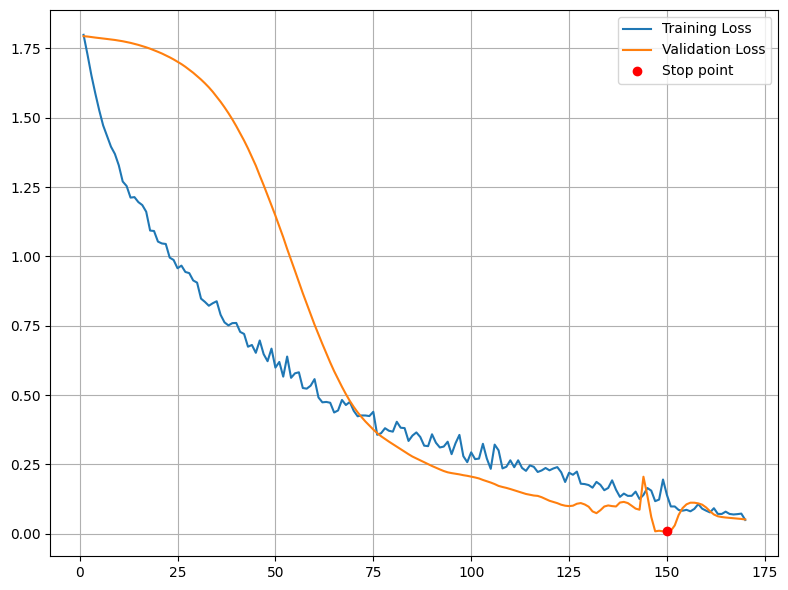

In [26]:
one_fold_data = loss_all_folds[4]
visualize_loss_graph(one_fold_data, title="Loss graph for first fold")

## Evaluation and metric testing

<Axes: >

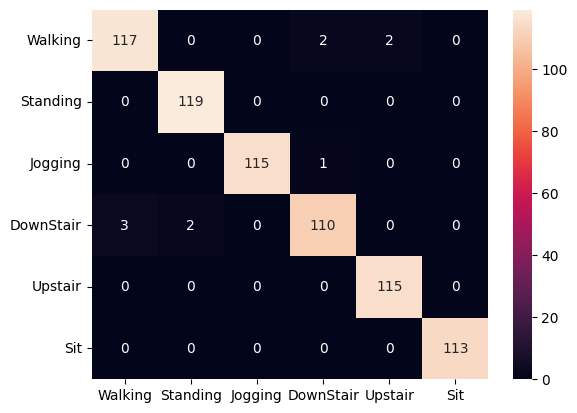

In [27]:
all_test_with_label = [label_list[i] for i in all_test]
all_pred_with_label = [label_list[i] for i in all_pred]

cf = confusion_matrix(all_test_with_label, all_pred_with_label, labels=label_list)
sns.heatmap(cf, annot=True, xticklabels=eng_label_list, yticklabels=eng_label_list, fmt='g')

In [28]:
print("precision_recall_fscore_support: ")
print()
print(*eng_label_list, sep=" "*4)
print(*precision_recall_fscore_support(all_test_with_label, all_pred_with_label, labels=label_list), sep="\n")

precision_recall_fscore_support: 

Walking    Standing    Jogging    DownStair    Upstair    Sit
[0.975      0.98347107 1.         0.97345133 0.98290598 1.        ]
[0.96694215 1.         0.99137931 0.95652174 1.         1.        ]
[0.97095436 0.99166667 0.995671   0.96491228 0.99137931 1.        ]
[121 119 116 115 115 113]
